In [1]:
import argparse
import argparse
import sys
import torch

# 检查并移除 Jupyter 传递的参数
if any('--f=' in arg for arg in sys.argv):
    # 移除包含 '--f=' 的所有参数
    sys.argv = [arg for arg in sys.argv if not arg.startswith('--f=')]
def parse_args():
    parser = argparse.ArgumentParser(description="Train a Mixture-of-Experts model.")
    parser.add_argument("--epochs", type=int, default=200, help="Number of epochs to train.")
    parser.add_argument("--batch_size", type=int, default=128, help="Batch size for training.")
    parser.add_argument("--input_size", type=int, default=10, help="Input size for the moe.")
    parser.add_argument("--num_experts", type=int, default=2, help="Number of experts.")
    parser.add_argument("--hidden_size", type=int, default=10, help="Hidden size for the moe.")
    parser.add_argument("--depth", type=int, default=10, help="Depth of the experts.")
    parser.add_argument("--output_size", type=int, default=10, help="Output size for the experts.")
    parser.add_argument("--activation", type=str, default="tanh", help="Activation function for the moe.")
    parser.add_argument("--k", type=int, default=1, help="Top-k experts to use.")
    parser.add_argument("--loss_coef", type=float, default=1e-2, help="Coefficient for the loss.")
    parser.add_argument("--smooth_steps",type=int,default=1,help="number of steps for smooth mode")
    parser.add_argument("--smooth_lb",type=int,default=200,help="number lower bound of steps for smooth mode")
    parser.add_argument("--seed",type=int,default=1234) #1234
    return parser.parse_args()
args=parse_args()
torch.manual_seed(args.seed)
iteration= (60000 // args.batch_size) * args.epochs
print("iteration:",iteration)

iteration: 93600


正在下载/加载 MNIST 训练数据集...
数据集加载完成。

--- 第一批数据结果 ---
图片张量形状 (Batch, C, H, W): torch.Size([4, 1, 28, 28])
标签张量形状 (Batch): torch.Size([4])

--- 图像 1 ---
  标签: 6
  部分像素值 (前5x5):
tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242]])
--------------------
--- 图像 2 ---
  标签: 6
  部分像素值 (前5x5):
tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242]])
--------------------
--- 图像 3 ---
  标签: 3
  部分像素值 (前5x5):
tensor([[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
        [-0.4242, -0.4242, -0.4242, -0.4242, -0.424

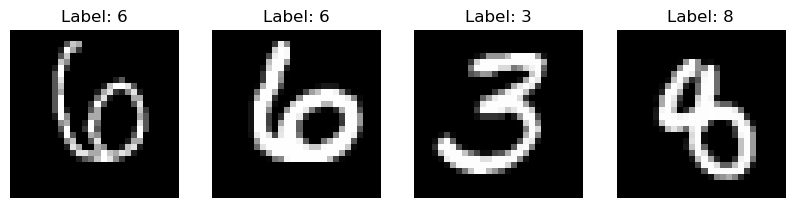

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # 用于可视化，可选

# 1. 定义数据预处理步骤
# 转换为 Tensor，并进行标准化（这是深度学习的标准步骤）
transform = transforms.Compose([
    transforms.ToTensor(),
    # MNIST的均值和标准差，用于将像素值归一化到 [-1, 1] 左右
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. 下载并加载数据集
# root='.' 表示下载到当前文件夹
# train=True 表示下载训练集 (共60000张)
# download=True 表示如果本地没有，则下载
print("正在下载/加载 MNIST 训练数据集...")
train_dataset = torchvision.datasets.MNIST(root='/home/zhy/Zhou/mixture_of_experts/_image_run/MINST/', 
                                           train=True, 
                                           transform=transform, 
                                           download=True)
print("数据集加载完成。")

# 3. 使用 DataLoader 载入数据
# 设置一个较小的 batch_size 方便查看结果
batch_size = 4
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

# 4. 取出并打印第一批数据
# 迭代器next()方法取出第一批数据
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("\n--- 第一批数据结果 ---")
print(f"图片张量形状 (Batch, C, H, W): {images.shape}")
print(f"标签张量形状 (Batch): {labels.shape}\n")

# 5. 打印前4张图片的信息
for i in range(batch_size):
    print(f"--- 图像 {i+1} ---")
    
    # 打印标签
    print(f"  标签: {labels[i].item()}")
    
    # 打印部分像素值 (张量切片)
    # 形状是 (1, 28, 28)，这里打印第0通道的前5行5列的像素值
    print("  部分像素值 (前5x5):")
    print(images[i, 0, :5, :5])
    print("-" * 20)
# （接上面的代码，在第5步之后运行）
fig, axes = plt.subplots(1, batch_size, figsize=(10, 3))
for i in range(batch_size):
    # 移除标准化并转为Numpy数组
    img = images[i].numpy().transpose((1, 2, 0)) # 将(C, H, W)转为(H, W, C)
    
    # 因为图像是归一化过的，这里需要简单的反归一化来正确显示
    # 仅为了显示效果，我们直接裁剪到有效范围
    axes[i].imshow(img.squeeze(), cmap='gray') 
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off')

plt.show()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from moe import *
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
print(f"使用的设备: {device}")
net = MoE_vision(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef,activation=nn.ReLU())
# 打印模型结构
print("---  模型结构 ---")
print(net)

# 检查输入/输出尺寸
# 假设批量大小为 64，输入是 (64, 1, 28, 28)
input_tensor = torch.randn(64, 1, 28, 28) 
output , loss= net(input_tensor)
print(f"\n输入尺寸: {input_tensor.shape}")
print(f"输出尺寸: {output.shape}") 
# 预期输出: torch.Size([64, 10])

使用的设备: cuda:7
=== Trainable parameters ===
Total trainable params: 12994

---  模型结构 ---
MoE_vision(
  (activation): ReLU()
  (trans_layer): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
  )
  (moe): ModuleList(
    (0): MoE(
      (experts): ModuleList(
        (0): Expert(
          (activation): ReLU()
          (net): ModuleList(
            (0-1): 2 x Linear(in_features=10, out_features=10, bias=True)
          )
        )
      )
      (gating_network): Gate_fcnn(
        (fc): Sequential(
          (0): Linear(in_features=10, out_features=1, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1, out_features=1, bias=True)
        )
        (noisy): Linear(in_features=10, out_features=1, bias=True)
        (softplus): Softplus(beta=1.0, threshold=20.0)
      )
    )
    (1-10): 10 x MoE(
      (experts): ModuleList(
        (0-1): 2 x Expert(
          (activation): ReLU()
          (net): ModuleList(
            (0-1): 2 x

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
# 假设 LeNet5 类已定义 (使用上一个回答中的代码)

# --- 0. 环境准备：设备、数据加载 ---

# 检查是否有GPU可用

net = MoE_vision(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef,activation=nn.ReLU()).to(device)

# 数据预处理（与之前相同）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 重新加载训练集和测试集 (下载/加载)
train_dataset = torchvision.datasets.MNIST(root='/home/zhy/Zhou/mixture_of_experts/_image_run/MINST/', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='/home/zhy/Zhou/mixture_of_experts/_image_run/MINST/', train=False, transform=transform, download=True)

# 定义超参数
BATCH_SIZE = 64 # LeNet通常可以使用较大的Batch Size
epochs = 60 # 沿用您最初设定的epochs

# 数据加载器
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


# --- 1. 模型、优化器和损失函数设置 ---

# 实例化模型并移动到指定设备
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 45], gamma=0.1)


# --- 2. 训练主循环 ---
print("\n--- 开始训练 ---")


step_count=args.smooth_steps

for epoch in range(args.epochs):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    running_aux_loss = 0.0
    scheduler.step()
    
    step_count -=1
    for j in range(len(net.moe)):
        if net.moe[j].smooth and step_count<=0:
            net.moe[j].smoothing(epoch,args.smooth_lb)
            step_count=args.smooth_steps
        elif step_count<=0 :
            net.moe[j].smoothing(epoch,args.smooth_lb)
            step_count=args.smooth_steps

    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        # inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize

        # outputs, aux_loss= MoE(inputs)
        outputs ,auxloss= net(inputs)

        loss = criterion(outputs, labels)

        # total_loss =loss+ aux_loss
        total_loss =loss

        total_loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # running_aux_loss += aux_loss.item()
        
        if i % 100== 99:    # print every 100 mini-batches
            print(f'[{epoch + 1:4d}, {i + 1:5d}] loss: {running_loss / 100:.3f}, aux_loss: {running_aux_loss/100:.3f}')
            running_loss = 0.0
            running_aux_loss = 0.0


print('Finished Training')


# 保存训练好的模型（可选）
PATH = '/home/zhy/Zhou/mixture_of_experts/_image_run/saved_cnn/mnist_lenet5.pth'
torch.save(net.state_dict(), PATH)

=== Trainable parameters ===
Total trainable params: 12994


--- 开始训练 ---


/home/zhy/anaconda3/envs/env-zqh/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


[   1,   100] loss: 1.721, aux_loss: 0.000
[   1,   200] loss: 1.410, aux_loss: 0.000
[   1,   300] loss: 1.576, aux_loss: 0.000
[   1,   400] loss: 1.585, aux_loss: 0.000
[   1,   500] loss: 1.659, aux_loss: 0.000
[   1,   600] loss: 1.894, aux_loss: 0.000
[   1,   700] loss: 1.817, aux_loss: 0.000
[   1,   800] loss: 1.764, aux_loss: 0.000
[   1,   900] loss: 1.730, aux_loss: 0.000
[   2,   100] loss: 1.709, aux_loss: 0.000
[   2,   200] loss: 1.685, aux_loss: 0.000
[   2,   300] loss: 1.672, aux_loss: 0.000
[   2,   400] loss: 1.813, aux_loss: 0.000
[   2,   500] loss: 1.861, aux_loss: 0.000
[   2,   600] loss: 1.773, aux_loss: 0.000


In [ ]:
net =  MoE_vision(args.input_size, args.num_experts, args.hidden_size, args.depth, args.output_size, args.k, args.loss_coef,activation=nn.ReLU()).to(device)

net.load_state_dict(torch.load(PATH, weights_only=True))
# 运行评估函数（可选，但推荐）
def evaluate_model():
    net.eval() # 设置模型为评估模式
    correct = 0
    total = 0
    with torch.no_grad(): # 评估时不需要计算梯度
        for data in test_loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1) # 获取预测结果
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'\n在 10000 张测试图片上的准确率: {100 * correct / total:.2f} %')

evaluate_model()



在 10000 张测试图片上的准确率: 99.30 %
